In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import scrublet as scr
import celltypist
from celltypist import models
import decoupler as dc
import matplotlib.pyplot as plt
import seaborn as sns
sc.set_figure_params(dpi=150)

# Import raw files

In [3]:
inpath="/home/lugli/spuccio/Projects/SP039/FileH5AD_input/"

In [5]:
MB_10 = sc.read(inpath+"MB_10.h5ad")
MB_4 = sc.read(inpath+"MB_4.h5ad")
MB_5 = sc.read(inpath+"MB_5.h5ad")
MB_8 = sc.read(inpath+"MB_8.h5ad")
MB_9 = sc.read(inpath+"MB_9.h5ad")
run_MB_12 = sc.read(inpath+"MB_12.h5ad")
run_MB_14 = sc.read(inpath+"MB_14.h5ad")
run_MB_15 = sc.read(inpath+"MB_15.h5ad")
run_MB_17 = sc.read(inpath+"MB_17.h5ad")
run_MB_20 = sc.read(inpath+"MB_20.h5ad")

# Read Metadata

In [6]:
metadata = pd.read_excel('Metadata2.xlsx')

In [7]:
metadata['Sample'] =   [ 'Patient' + str(col) for col in metadata.Sample]

# Fix Metadata 

In [8]:
def fixmeta(metadata,sample,adata):
    tmp1 = metadata.loc[metadata['SampleID'] == sample].loc[metadata.loc[metadata['SampleID'] == sample].index.repeat(adata.shape[0])]
    tmp1.reset_index(drop=True,inplace=True)
    tmp1.set_index( sample+"_"  + tmp1.index.astype(str),inplace=True) 
    adata.obs = tmp1
    return adata

In [11]:
MB_10 = fixmeta(metadata,"MB_10",MB_10)
MB_4 = fixmeta(metadata,"MB_4",MB_4)
MB_5 = fixmeta(metadata,"MB_5",MB_5)
MB_8 = fixmeta(metadata,"MB_8",MB_8)
MB_9 = fixmeta(metadata,"MB_9",MB_9)
run_MB_12 = fixmeta(metadata,"MB_12",run_MB_12)
run_MB_14 = fixmeta(metadata,"MB_14",run_MB_14)
run_MB_15 = fixmeta(metadata,"MB_15",run_MB_15)
run_MB_17 = fixmeta(metadata,"MB_17",run_MB_17)
run_MB_20 = fixmeta(metadata,"MB_20",run_MB_20)

# Concatenate 

In [12]:
MB_10.var_names_make_unique()
MB_4.var_names_make_unique()
MB_5.var_names_make_unique()
MB_8.var_names_make_unique()
MB_9.var_names_make_unique()
run_MB_12.var_names_make_unique()
run_MB_14.var_names_make_unique()
run_MB_15.var_names_make_unique()
run_MB_17.var_names_make_unique()
run_MB_20.var_names_make_unique()

In [13]:
adata = MB_10.concatenate(MB_4,MB_5,MB_8,run_MB_12,run_MB_14,run_MB_15,run_MB_17,run_MB_20,
                         index_unique=None)

In [14]:
del(MB_10,MB_4,MB_5,MB_8,run_MB_12,run_MB_14,run_MB_15,run_MB_17,run_MB_20)

In [15]:
print(adata.obs['SampleID'].value_counts())
adata

MB_4     2057
MB_8     1831
MB_15    1729
MB_20    1605
MB_14    1539
MB_12    1259
MB_17    1257
MB_5     1140
MB_10     914
Name: SampleID, dtype: int64


AnnData object with n_obs × n_vars = 13331 × 33538
    obs: 'SampleID', 'GEO_RNA', 'Cohort', 'Type', 'Subtype', 'Diagnosis', 'Grade', 'Location', 'IDH1_Status', 'EGFR_Status', 'MGMT', 'CellCount', 'Sample', 'Sex', 'Age', 'Sorted', 'MET', 'batch'
    var: 'gene_ids', 'feature_types', 'genome'

In [16]:
adata.layers['raw'] = adata.X 

# Calculate QC

In [17]:
# mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith('MT-') 
# ribosomal genes
adata.var['ribo'] = adata.var_names.str.startswith(("RPS","RPL"))
# hemoglobin genes.
adata.var['hb'] = adata.var_names.str.contains(("^HB[^(P)]"))

In [18]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo','hb'], percent_top=None, log1p=False, inplace=True)

In [19]:
mito_genes = adata.var_names.str.startswith('MT-')
adata.obs['percent_mt2'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1)

In [20]:
adata

AnnData object with n_obs × n_vars = 13331 × 33538
    obs: 'SampleID', 'GEO_RNA', 'Cohort', 'Type', 'Subtype', 'Diagnosis', 'Grade', 'Location', 'IDH1_Status', 'EGFR_Status', 'MGMT', 'CellCount', 'Sample', 'Sex', 'Age', 'Sorted', 'MET', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'raw'

# Plot QC

... storing 'SampleID' as categorical
... storing 'GEO_RNA' as categorical
... storing 'Cohort' as categorical
... storing 'Type' as categorical
... storing 'Subtype' as categorical
... storing 'Diagnosis' as categorical
... storing 'Grade' as categorical
... storing 'Location' as categorical
... storing 'IDH1_Status' as categorical
... storing 'EGFR_Status' as categorical
... storing 'MGMT' as categorical
... storing 'Sample' as categorical
... storing 'Sex' as categorical
... storing 'Age' as categorical
... storing 'Sorted' as categorical
... storing 'MET' as categorical


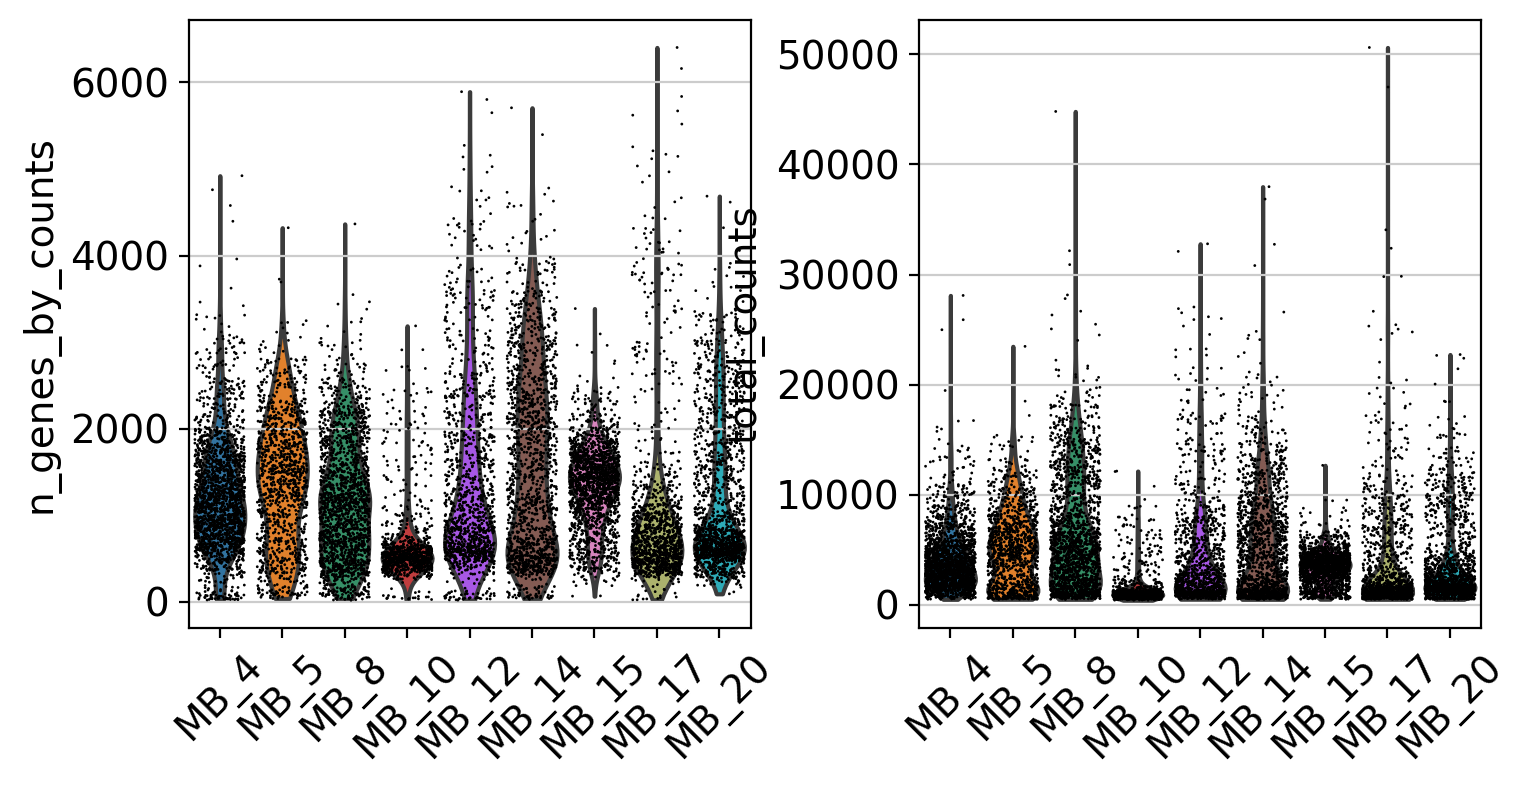

In [21]:
sc.set_figure_params(dpi=100)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'],
             jitter=0.4, groupby = 'SampleID', rotation= 45)

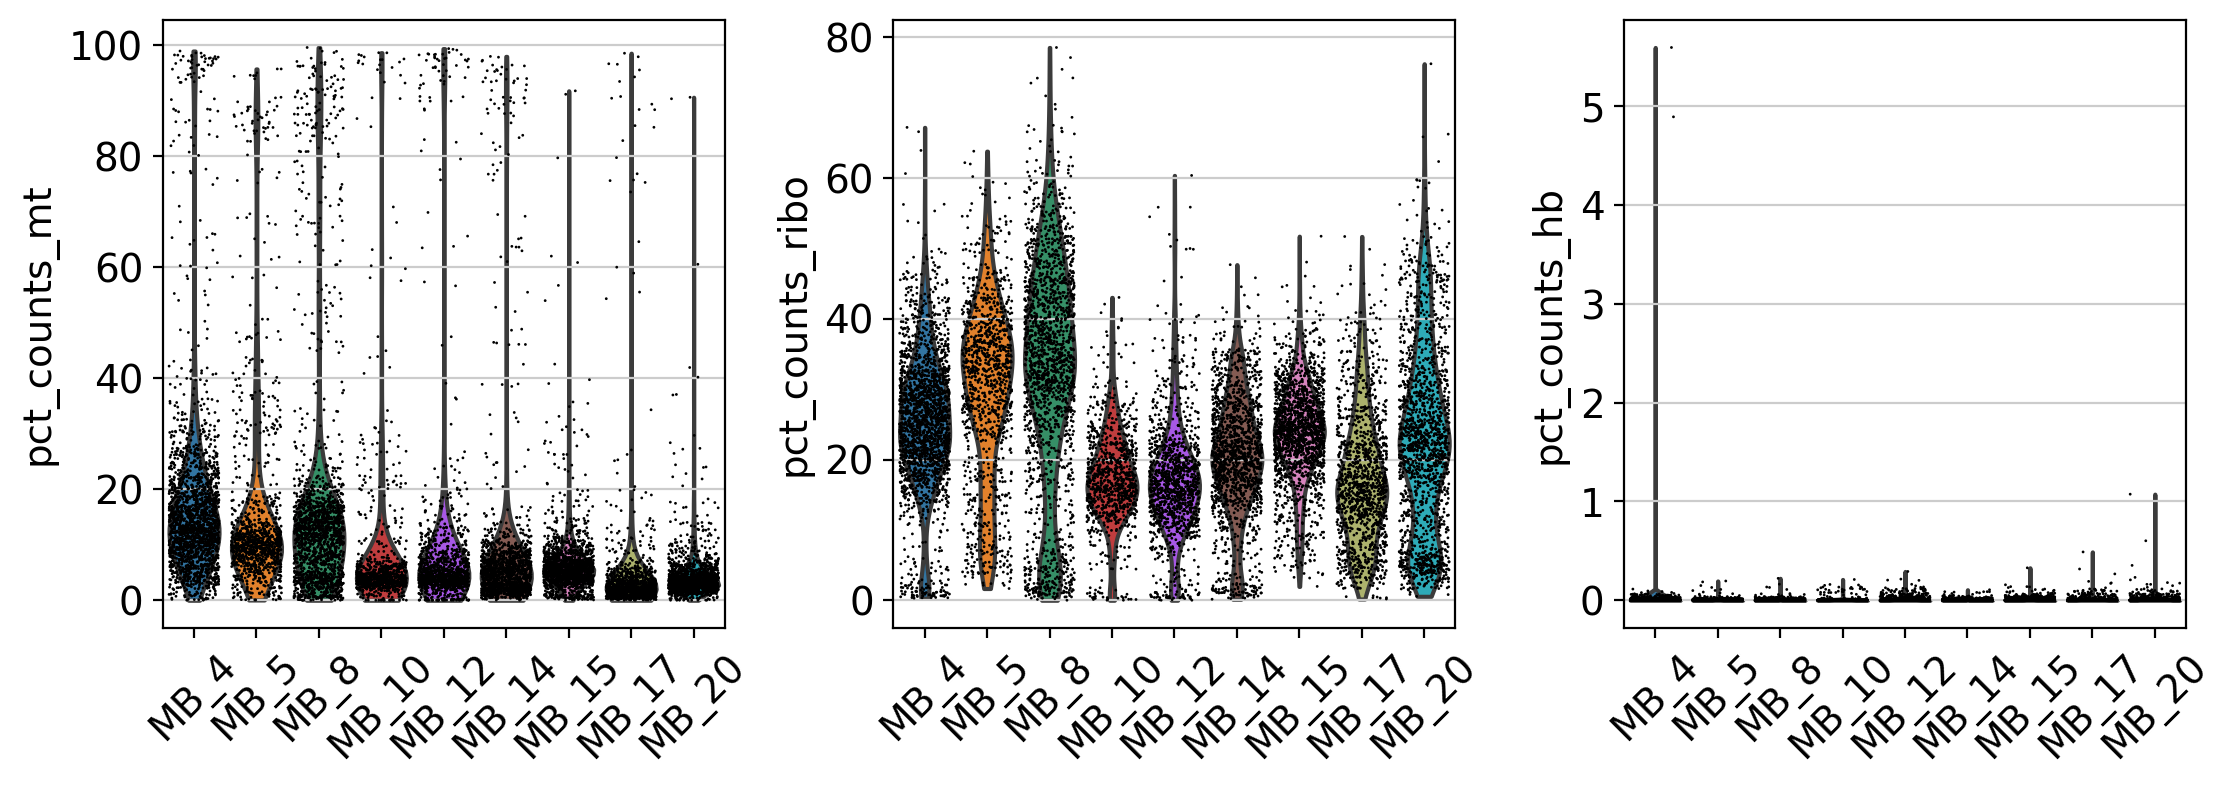

In [22]:
sc.pl.violin(adata, ['pct_counts_mt','pct_counts_ribo', 'pct_counts_hb'],
             jitter=0.4, groupby = 'SampleID', rotation= 45)

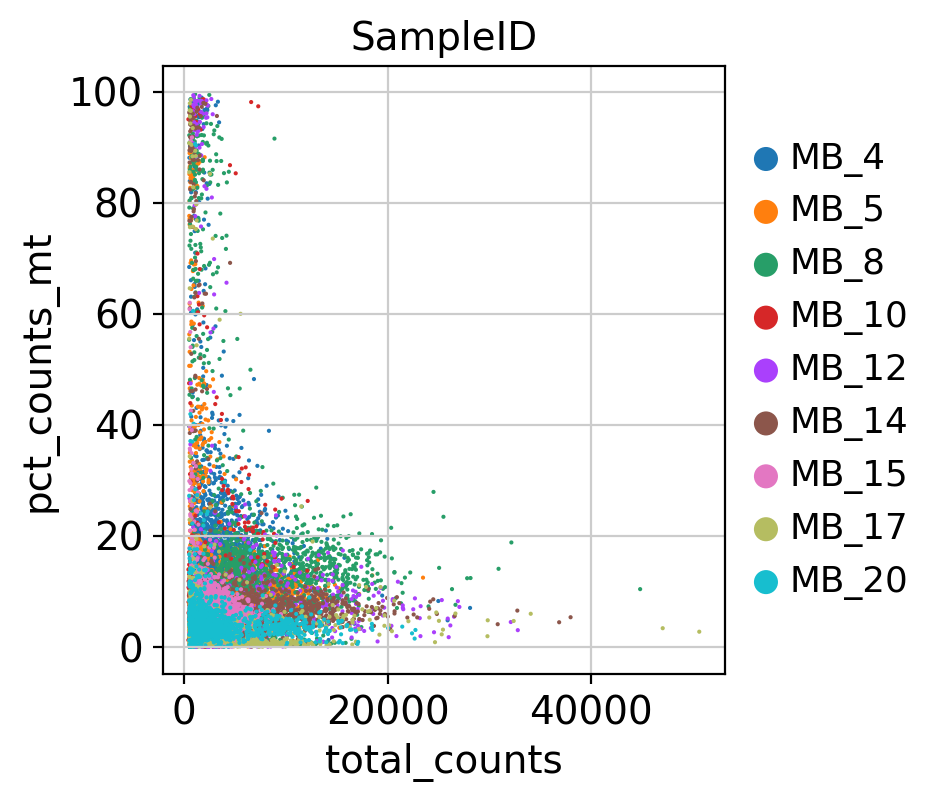

In [23]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', color="SampleID")

# Filtering

In [24]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

print(adata.n_obs, adata.n_vars)

12951 20333


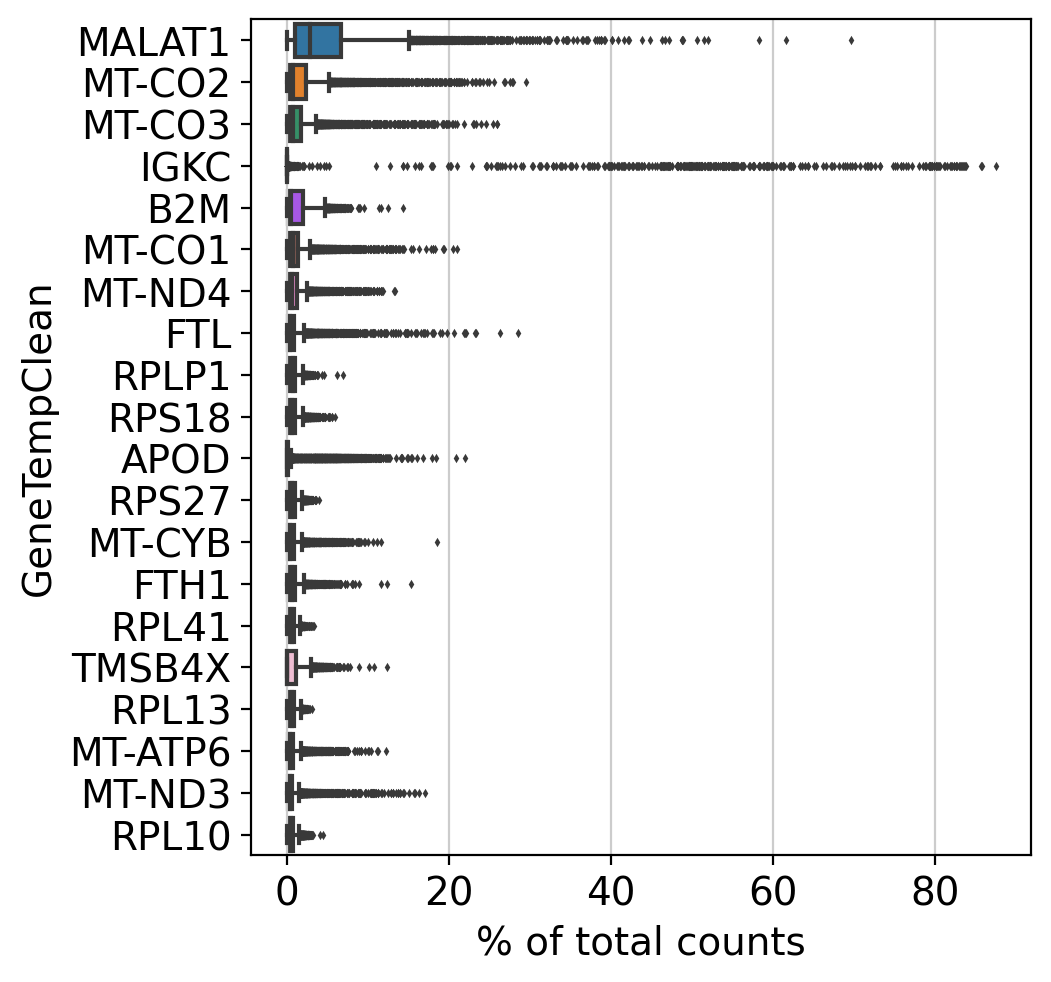

In [25]:
sc.pl.highest_expr_genes(adata, n_top=20)

# Mito/Ribo filtering

In [26]:
#adata = adata[adata.obs['pct_counts_mt'] < 20, :]

# filter for percent ribo > 0.05
#adata = adata[adata.obs['pct_counts_ribo'] > 5, :]
adata = adata[adata.obs['pct_counts_hb'] < 2, :]
print("Remaining cells %d"%adata.n_obs)

Remaining cells 12949


# Plot filtered QC

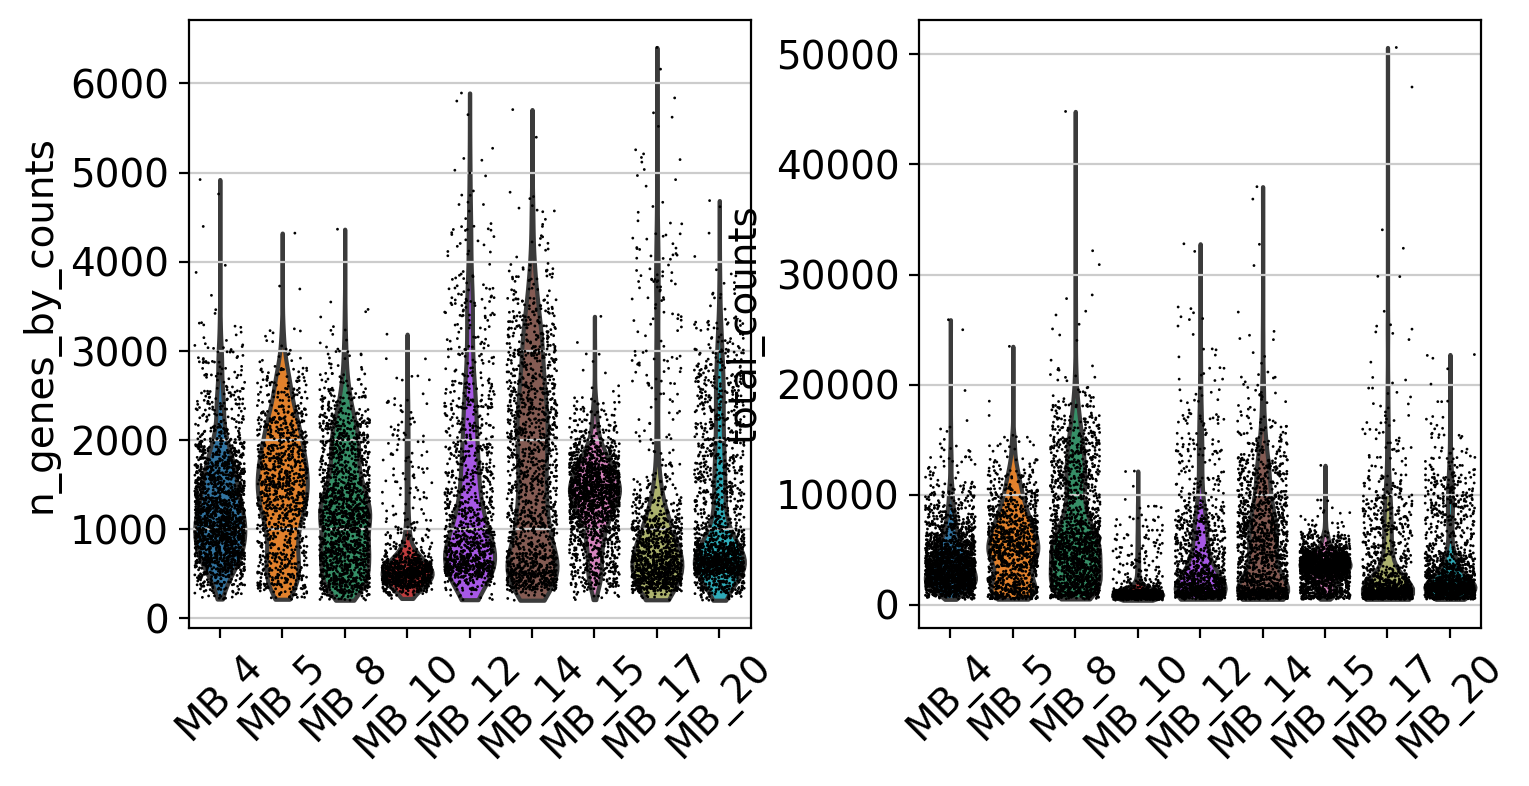

In [27]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'],
             jitter=0.4, groupby = 'SampleID', rotation= 45)

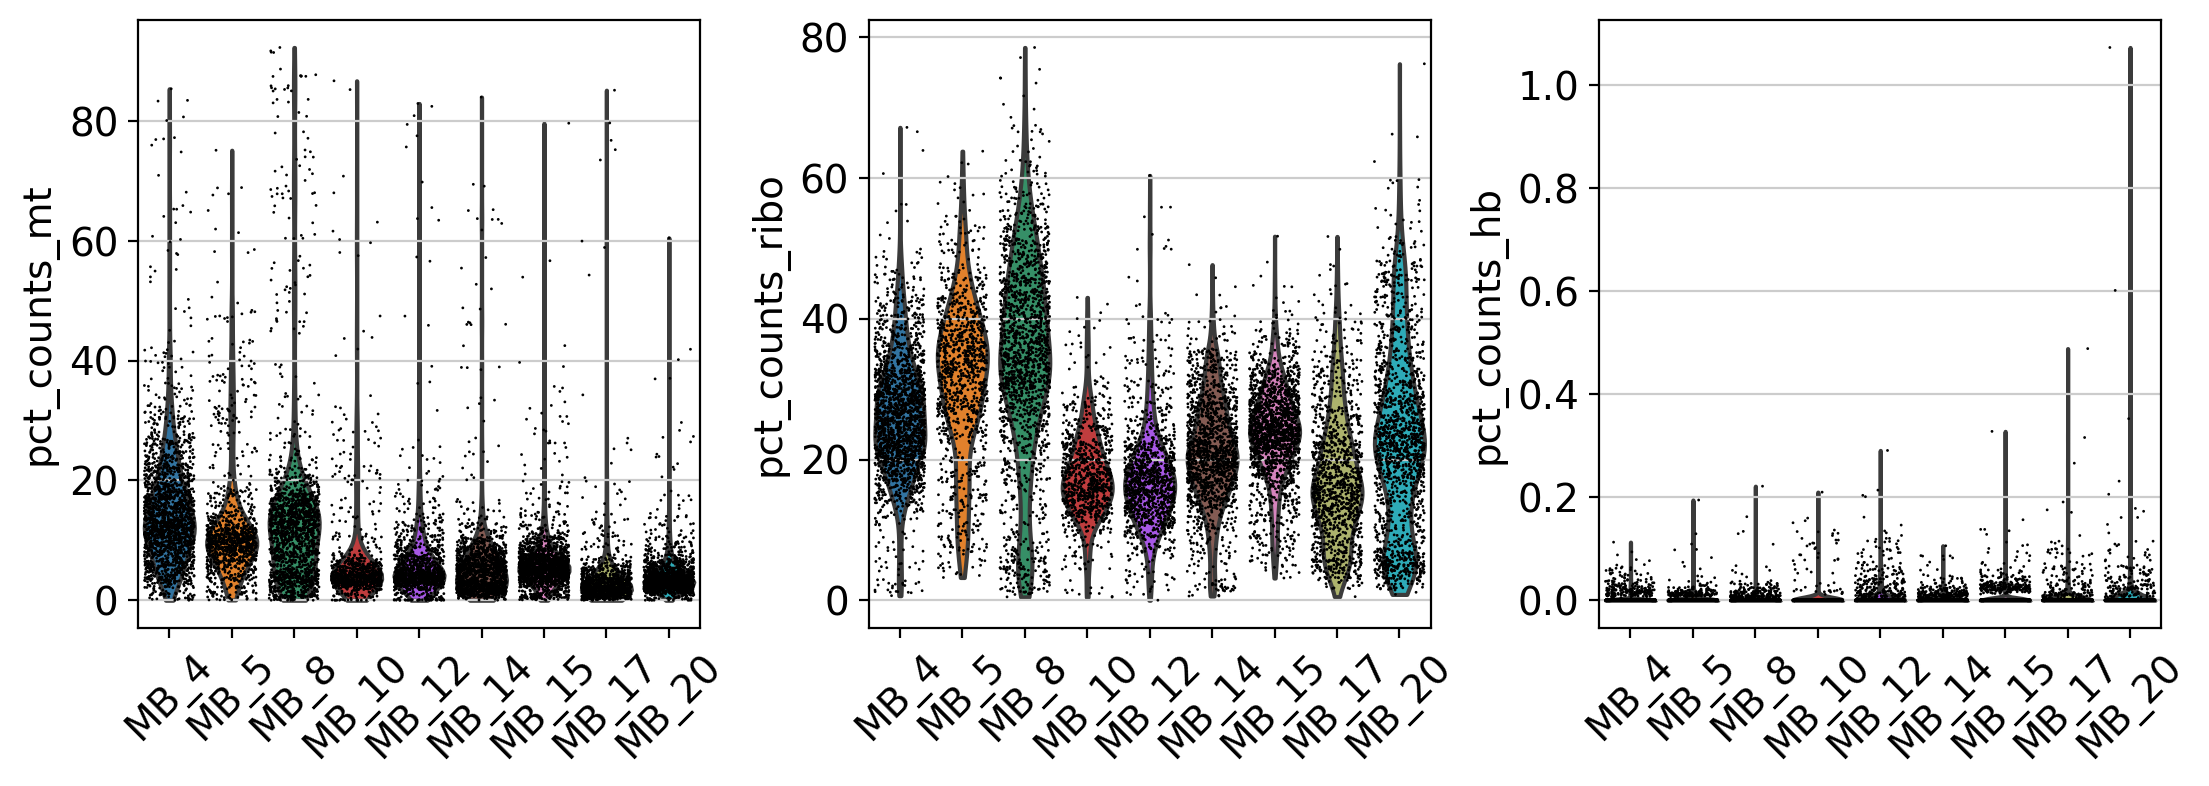

In [28]:
sc.pl.violin(adata, ['pct_counts_mt','pct_counts_ribo', 'pct_counts_hb'],
             jitter=0.4, groupby = 'SampleID', rotation= 45)

# Filter genes

In [29]:
mito_gene_names = sc.queries.mitochondrial_genes("hsapiens")

In [30]:
mito_gene_indicator = np.in1d(adata.var_names, mito_gene_names)

In [31]:
adata = adata[:, ~mito_gene_indicator]

In [32]:
print(adata.n_obs, adata.n_vars)
malat1 = adata.var_names.str.startswith('MALAT1')
# we need to redefine the mito_genes since they were first 
# calculated on the full object before removing low expressed genes.
ribo_genes = adata.var_names.str.startswith(("RPL","RPS"))
hb_genes = adata.var_names.str.contains('^HB[^(P)]')

remove = np.add(ribo_genes, malat1)
remove = np.add(remove, hb_genes)
keep = np.invert(remove)

adata = adata[:,keep]

print(adata.n_obs, adata.n_vars)

12949 20320
12949 20211


# Calculate cell-cycle scores

In [33]:
cell_cycle_genes = [x.strip() for x in open('/home/lugli/spuccio/Projects/SP035_TregIntegration/Analysis/regev_lab_cell_cycle_genes_homo.txt')]
print(len(cell_cycle_genes))
# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
print(len(cell_cycle_genes))

90
90


In [34]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

... storing 'phase' as categorical


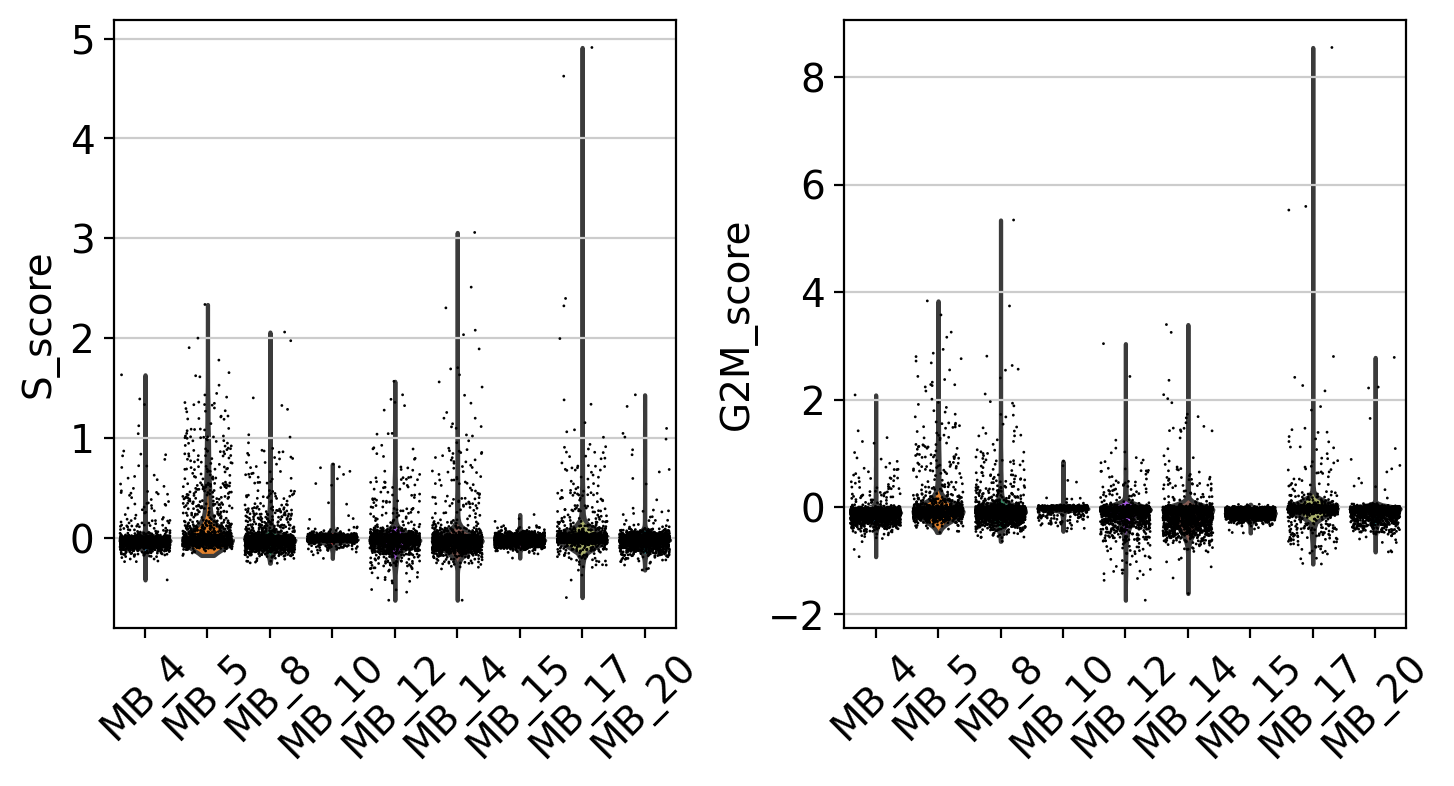

In [35]:
sc.pl.violin(adata, ['S_score', 'G2M_score'],
             jitter=0.4, groupby = 'SampleID', rotation=45)

# Predict doublets

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.67
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 23.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.2%
Elapsed time: 11.0 seconds


7

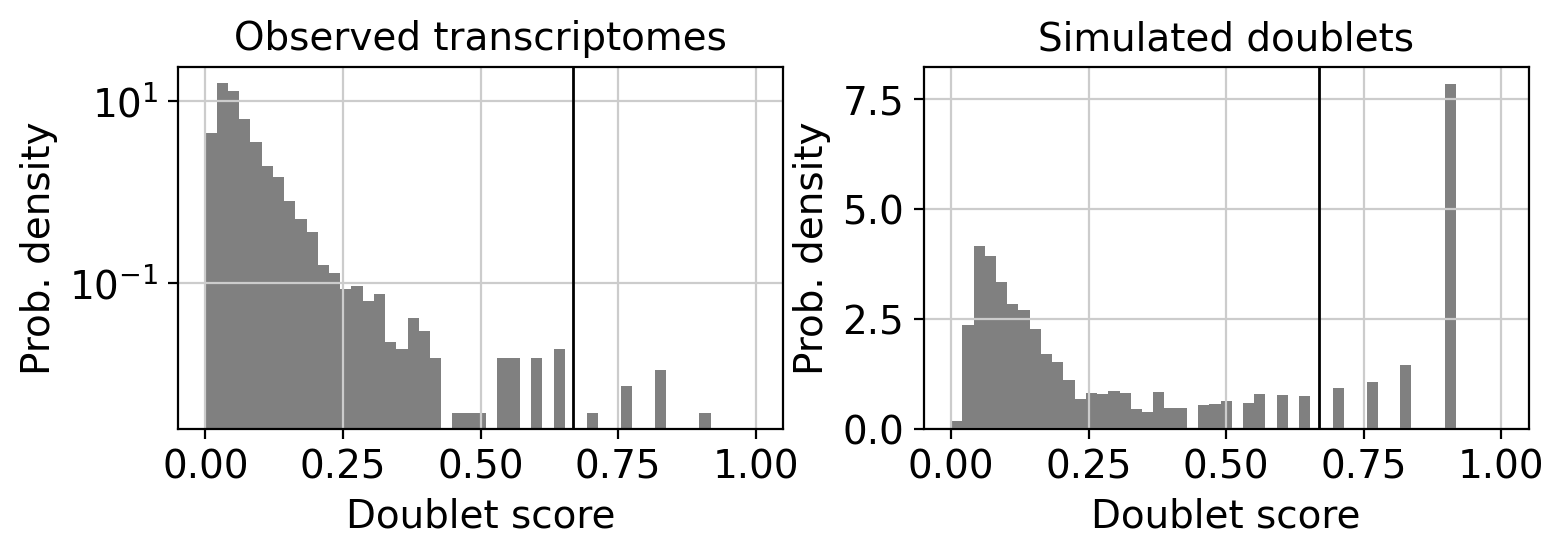

In [36]:
scrub = scr.Scrublet(adata.layers['raw'])
adata.obs['doublet_scores'], adata.obs['predicted_doublets'] = scrub.scrub_doublets()
scrub.plot_histogram()

sum(adata.obs['predicted_doublets'])

In [37]:
# add in column with singlet/doublet instead of True/False
adata.obs['doublet_info'] = adata.obs["predicted_doublets"].astype(str)

... storing 'doublet_info' as categorical


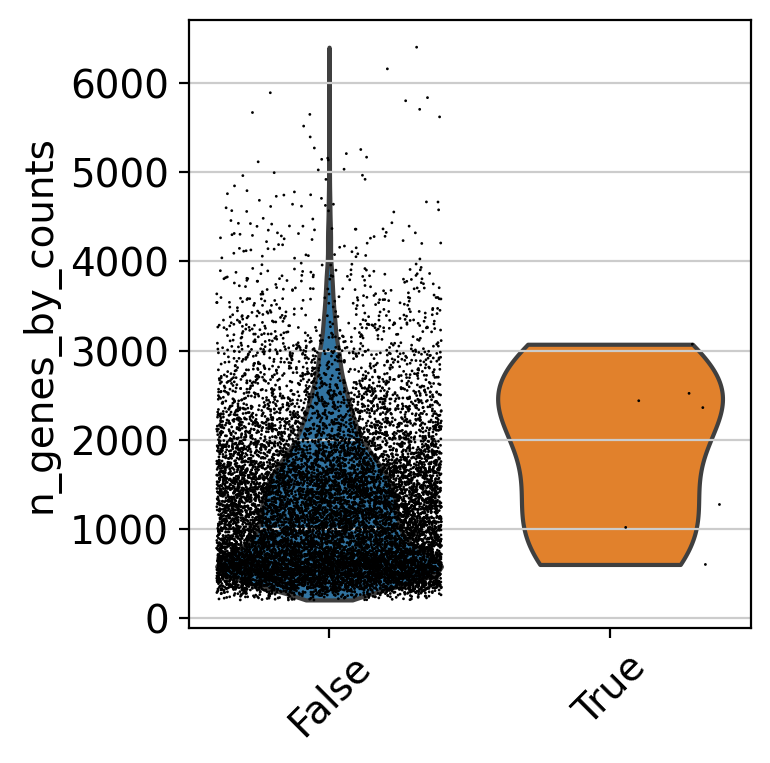

In [38]:
sc.pl.violin(adata, 'n_genes_by_counts',jitter=0.4, groupby = 'doublet_info', rotation=45)

In [39]:
adata = adata[adata.obs['doublet_info'] == "False",:]

# Processing 

In [40]:
#adata = adata[adata.obs.n_genes_by_counts < 3000, :]
# save normalized counts in raw slot.
adata.raw = adata
# normalize to depth 10 000
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
adata.layers['cpm'] = adata.X
# logaritmize
sc.pp.log1p(adata)
adata.layers['log1p'] = adata.X
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
# Filter higly variable genes
#adata.raw = adata

# scale
#sc.pp.scale(adata)

# Celltypist classification

In [41]:
sc.tl.pca(adata,svd_solver='arpack',copy=False)

In [42]:
sc.pp.neighbors(adata,n_neighbors=10, n_pcs=40)

In [43]:
sce.pp.harmony_integrate(adata, ['SampleID'])

2022-06-14 15:07:28,279 - harmonypy - INFO - Iteration 1 of 10
Iteration 1 of 10
2022-06-14 15:07:30,270 - harmonypy - INFO - Iteration 2 of 10
Iteration 2 of 10
2022-06-14 15:07:32,261 - harmonypy - INFO - Converged after 2 iterations
Converged after 2 iterations


In [44]:
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_pca_harmony')

In [45]:
sc.tl.umap(adata)

In [46]:
adata.obsm['X_umap_harmony'] = adata.obsm['X_umap']

In [47]:
adata

AnnData object with n_obs × n_vars = 12942 × 20211
    obs: 'SampleID', 'GEO_RNA', 'Cohort', 'Type', 'Subtype', 'Diagnosis', 'Grade', 'Location', 'IDH1_Status', 'EGFR_Status', 'MGMT', 'CellCount', 'Sample', 'Sex', 'Age', 'Sorted', 'MET', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'SampleID_colors', 'doublet_info_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'X_umap_harmony'
    varm: 'PCs'
    layers: 'raw', 'cpm', 'log1p'
    obsp: 'distances', 'connectivities'

In [48]:
models.download_models(force_update = True)

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 13
📂 Storing models in /home/lugli/spuccio/.celltypist/data/models
💾 Downloading model [1/13]: Immune_All_Low.pkl
💾 Downloading model [2/13]: Immune_All_High.pkl
💾 Downloading model [3/13]: Immune_All_PIP.pkl
💾 Downloading model [4/13]: Immune_All_AddPIP.pkl
💾 Downloading model [5/13]: COVID19_Immune_Landscape.pkl
💾 Downloading model [6/13]: Cells_Fetal_Lung.pkl
💾 Downloading model [7/13]: Cells_Intestinal_Tract.pkl
💾 Downloading model [8/13]: Cells_Lung_Airway.pkl
💾 Downloading model [9/13]: Developing_Mouse_Brain.pkl
💾 Downloading model [10/13]: Healthy_COVID19_PBMC.pkl
💾 Downloading model [11/13]: Human_Lung_Atlas.pkl
💾 Downloading model [12/13]: Nuclei_Lung_Airway.pkl
💾 Downloading model [13/13]: Pan_Fetal_Human.pkl


In [49]:
model = models.Model.load(model = 'Immune_All_High.pkl')

In [50]:
predictionsHigh = celltypist.annotate(adata, model = 'Immune_All_High.pkl', majority_voting = True)

🔬 Input data has 12942 cells and 20211 genes
🔗 Matching reference genes in the model
🧬 2747 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


In [51]:
#adata.obs['CellCount']= adata.obs['CellCount'].astype(int)

In [52]:
adata.obs['Sample'].value_counts()

Patient72    1986
Patient74    1733
Patient78    1725
Patient80    1598
Patient77    1481
Patient79    1238
Patient76    1210
Patient73    1078
Patient71     893
Name: Sample, dtype: int64

In [55]:
adata.write("/home/lugli/spuccio/Projects/SP039/FileH5AD_concatenated/Part1_M_GSE174401_PMID34035069.h5ad")

In [56]:
predictionsHigh.to_adata()

AnnData object with n_obs × n_vars = 12942 × 20211
    obs: 'SampleID', 'GEO_RNA', 'Cohort', 'Type', 'Subtype', 'Diagnosis', 'Grade', 'Location', 'IDH1_Status', 'EGFR_Status', 'MGMT', 'CellCount', 'Sample', 'Sex', 'Age', 'Sorted', 'MET', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'SampleID_colors', 'doublet_info_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'X_umap_harmony'
    varm: 'PCs'
    l

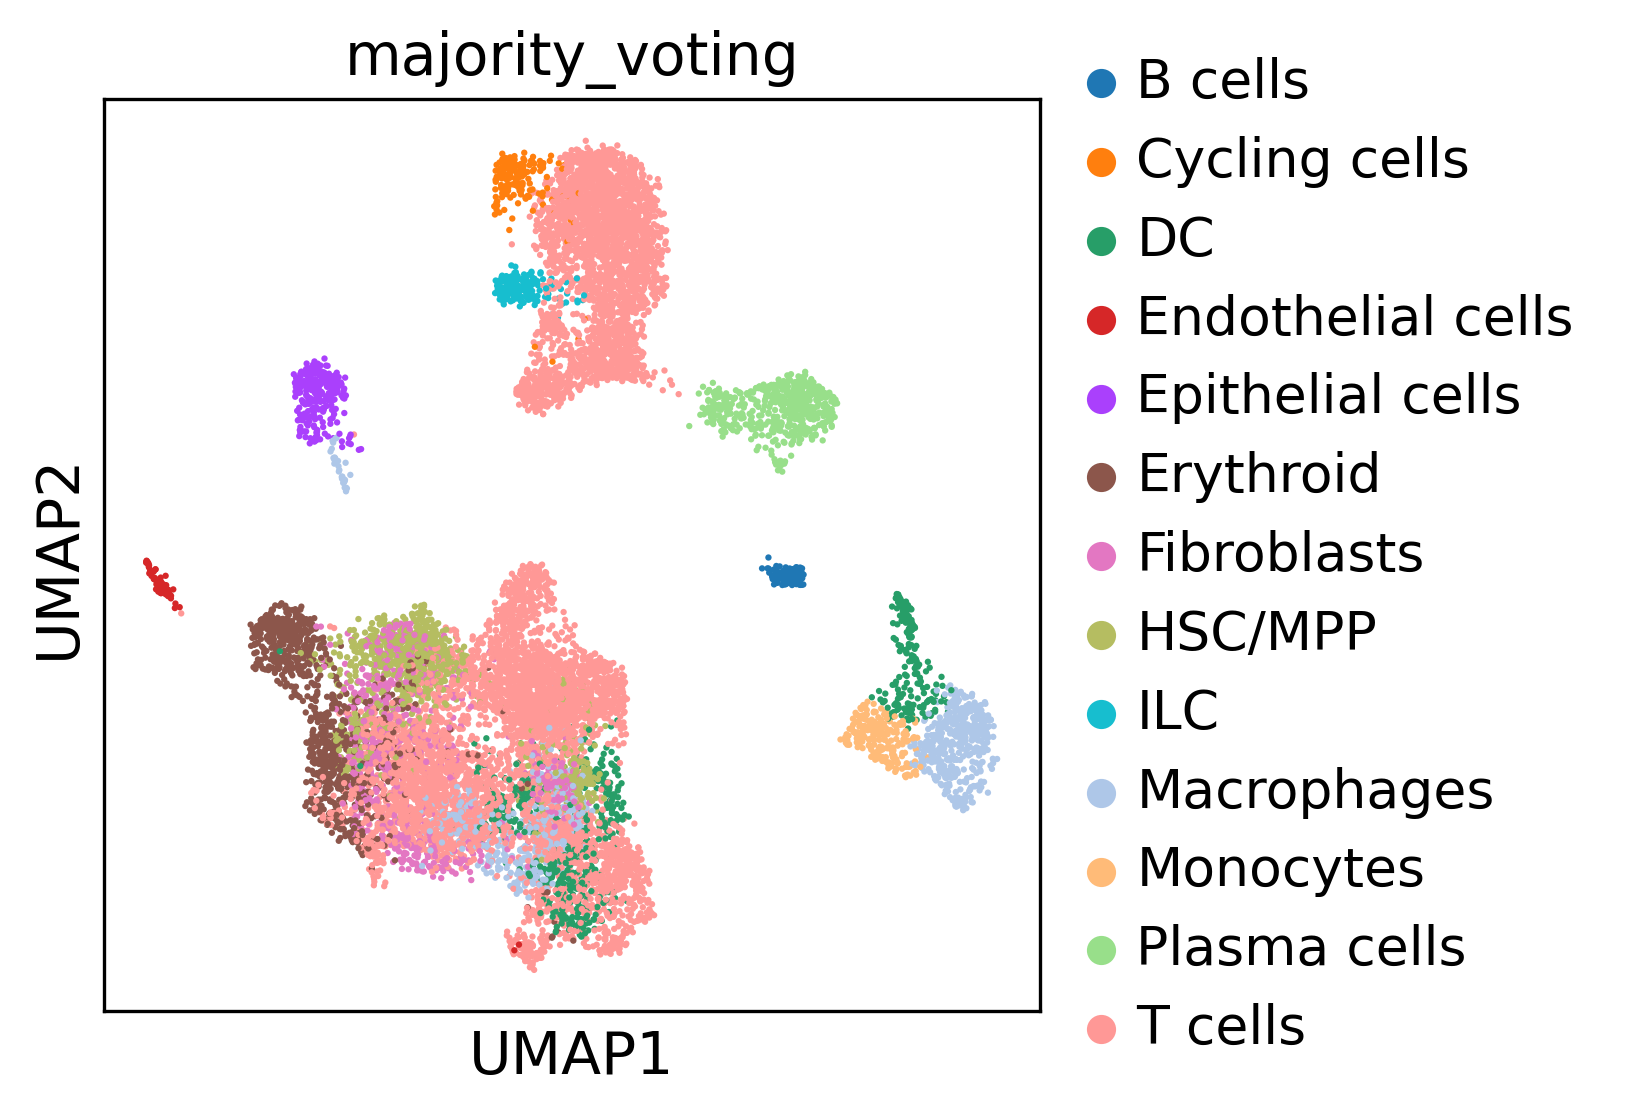

In [57]:
sc.set_figure_params(dpi=150)
sc.pl.umap(predictionsHigh.to_adata(), color='majority_voting')

# PanglaoDB classification

In [58]:
adata = adata[:, adata.var.highly_variable]

In [59]:
markers = dc.get_resource('PanglaoDB')
markers

label genesymbol canonical_marker         cell_type germ_layer human  \
0          CTRB1            False       Enterocytes   Endoderm  True   
1          CTRB1             True      Acinar cells   Endoderm  True   
2           KLK1             True      Acinar cells   Endoderm  True   
3           KLK1            False      Goblet cells   Endoderm  True   
4           KLK1            False  Epithelial cells   Mesoderm  True   
...          ...              ...               ...        ...   ...   
8472     SLC14A1             True  Urothelial cells   Mesoderm  True   
8473       UPK3A             True  Urothelial cells   Mesoderm  True   
8474       UPK1A             True  Urothelial cells   Mesoderm  True   
8475        UPK2             True  Urothelial cells   Mesoderm  True   
8476       UPK3B             True  Urothelial cells   Mesoderm  True   

label human_sensitivity human_specificity mouse mouse_sensitivity  \
0                   0.0        0.00439422  True        0.00331126   
1                   1.0       0.000628931  True          0.957143   
2              0.833333        0.00503145  True          0.314286   
3              0.588235        0.00503937  True          0.903226   
4                   0.0        0.00823306  True          0.225806   
...                 ...               ...   ...               ...   
8472                0.0         0.0181704  True               0.0   
8473                0.0               0.0  True               0.0   
8474                0.0               0.0  True               0.0   
8475                0.0               0.0  True               0.0   
8476                0.0               0.0  True               0.0   

label mouse_specificity ncbi_tax_id            organ ubiquitiousness  
0             0.0204803        9606         GI tract           0.017  
1             0.0159201        9606         Pancreas           0.017  
2             0.0128263        9606         Pancreas           0.013  
3             0.0124084        9606         GI tract           0.013  
4             0.0137585        9606       Epithelium           0.013  
...                 ...         ...              ...             ...  
8472                0.0        9606  Urinary bladder           0.008  
8473                0.0        9606  Urinary bladder             0.0  
8474                0.0        9606  Urinary bladder             0.0  
8475                0.0        9606  Urinary bladder             0.0  
8476                0.0        9606  Urinary bladder             0.0  

[8477 rows x 13 columns]

In [60]:
markers['organ'].value_counts()

Immune system         1775
Brain                 1589
GI tract               540
Kidney                 450
Reproductive           429
Connective tissue      413
Vasculature            372
Pancreas               365
Liver                  310
Epithelium             258
Blood                  247
Bone                   215
Lungs                  210
Skin                   172
Skeletal muscle        168
Olfactory system       136
Heart                  131
Smooth muscle          130
Eye                    122
Mammary gland           94
Zygote                  85
Embryo                  56
Placenta                28
Thymus                  27
Adrenal glands          25
Oral cavity             18
Thyroid                 14
Urinary bladder         11
Parathyroid glands      10
Name: organ, dtype: int64

In [61]:
# Filter by canonical_marker and human
markers = markers[(markers['human']=='True')&(markers['canonical_marker']=='True')]

# Remove duplicated entries
markers = markers[~markers.duplicated(['cell_type', 'genesymbol'])]
markers

label genesymbol canonical_marker                     cell_type germ_layer  \
1          CTRB1             True                  Acinar cells   Endoderm   
2           KLK1             True                  Acinar cells   Endoderm   
5           KLK1             True               Principal cells   Mesoderm   
7           KLK1             True  Plasmacytoid dendritic cells   Mesoderm   
8           KLK1             True             Endothelial cells   Mesoderm   
...          ...              ...                           ...        ...   
8472     SLC14A1             True              Urothelial cells   Mesoderm   
8473       UPK3A             True              Urothelial cells   Mesoderm   
8474       UPK1A             True              Urothelial cells   Mesoderm   
8475        UPK2             True              Urothelial cells   Mesoderm   
8476       UPK3B             True              Urothelial cells   Mesoderm   

label human human_sensitivity human_specificity mouse mouse_sensitivity  \
1      True               1.0       0.000628931  True          0.957143   
2      True          0.833333        0.00503145  True          0.314286   
5      True               0.0        0.00814536  True          0.285714   
7      True               0.0        0.00820189  True               1.0   
8      True               0.0        0.00841969  True               0.0   
...     ...               ...               ...   ...               ...   
8472   True               0.0         0.0181704  True               0.0   
8473   True               0.0               0.0  True               0.0   
8474   True               0.0               0.0  True               0.0   
8475   True               0.0               0.0  True               0.0   
8476   True               0.0               0.0  True               0.0   

label mouse_specificity ncbi_tax_id            organ ubiquitiousness  
1             0.0159201        9606         Pancreas           0.017  
2             0.0128263        9606         Pancreas           0.013  
5             0.0140583        9606           Kidney           0.013  
7             0.0129136        9606    Immune system           0.013  
8             0.0149153        9606      Vasculature           0.013  
...                 ...         ...              ...             ...  
8472                0.0        9606  Urinary bladder           0.008  
8473                0.0        9606  Urinary bladder             0.0  
8474                0.0        9606  Urinary bladder             0.0  
8475                0.0        9606  Urinary bladder             0.0  
8476                0.0        9606  Urinary bladder             0.0  

[5180 rows x 13 columns]

In [62]:
# Run leiden clustering algorithm
sc.tl.leiden(adata)

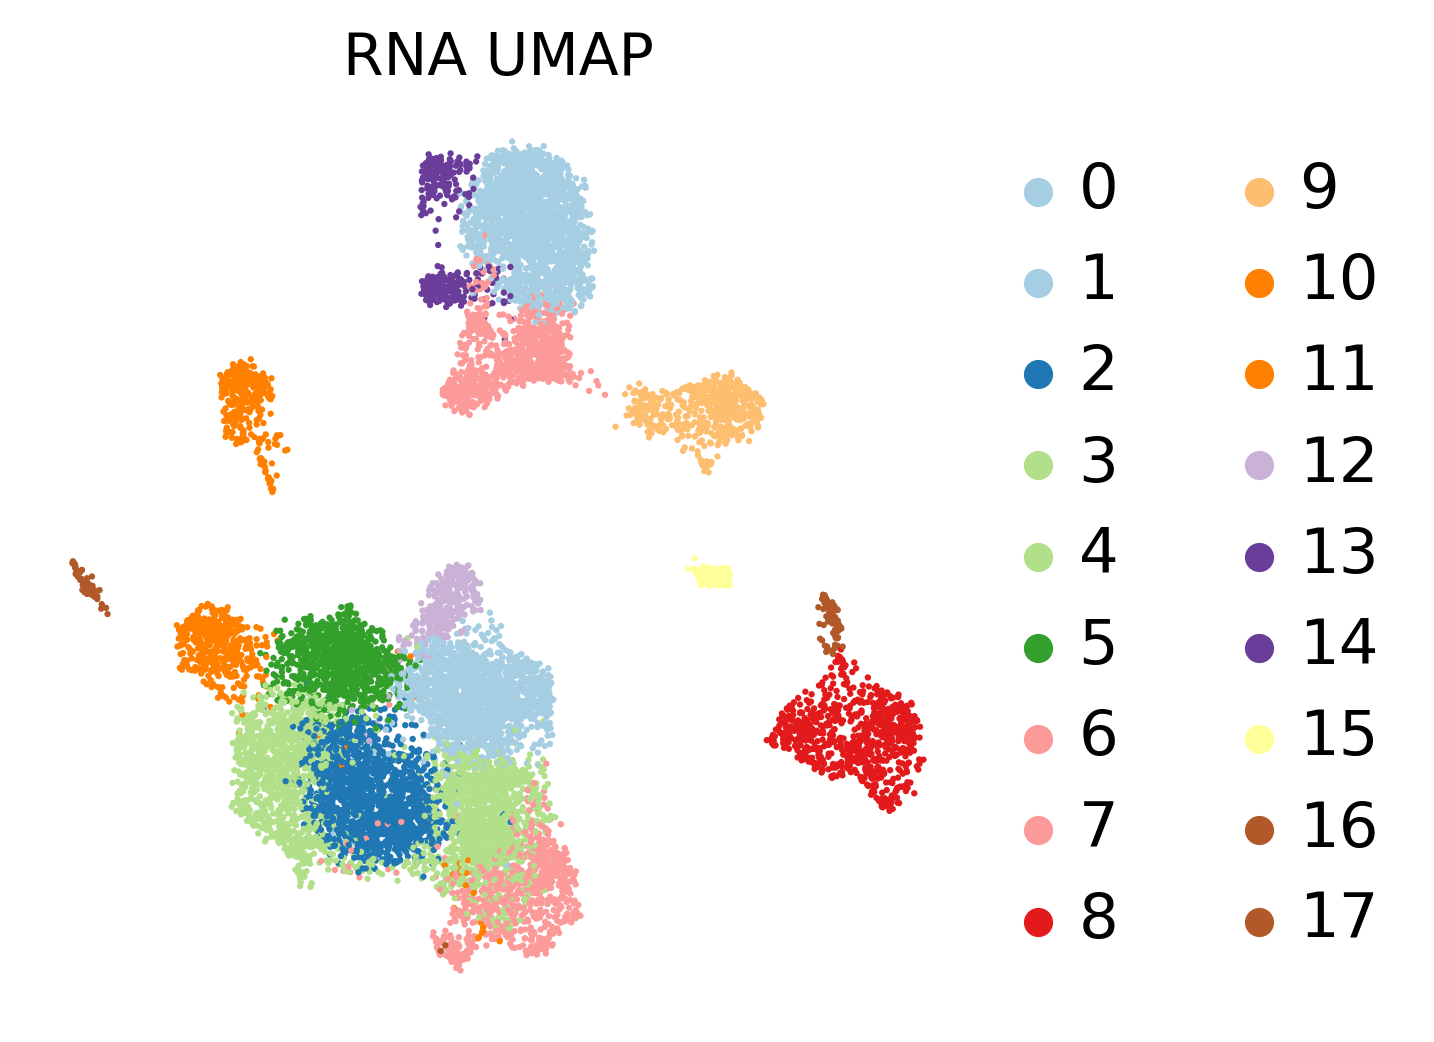

In [63]:
# Visualize
sc.pl.umap(adata, color='leiden', title='RNA UMAP',palette='Paired',
           frameon=False, legend_fontweight='normal', legend_fontsize=15)

In [64]:
dc.run_ora(mat=adata, net=markers, source='cell_type', target='genesymbol', min_n=3, verbose=True,use_raw=False)

Running ora on mat with 12942 samples and 4299 targets for 106 sources.


100%|██████████| 12942/12942 [00:04<00:00, 2764.45it/s]


In [65]:
adata.obsm['ora_estimate']

source      Acinar cells  Adipocytes  Alpha cells  Alveolar macrophages  \
MB_10_0         0.989412    0.511826    -0.000000              1.373509   
MB_10_1         0.989412    0.511826    -0.000000              1.373509   
MB_10_2        -0.000000    1.287916     1.032872              1.373509   
MB_10_3        -0.000000   -0.000000     1.032872              1.373509   
MB_10_5         0.989412   -0.000000    -0.000000             -0.000000   
...                  ...         ...          ...                   ...   
MB_20_1600      2.310657    2.241460    -0.000000             -0.000000   
MB_20_1601      2.310657    1.287916    -0.000000              1.373509   
MB_20_1602      5.586276    2.241460    -0.000000              1.373509   
MB_20_1603      2.310657    0.511826    -0.000000             -0.000000   
MB_20_1604      0.989412    0.511826    -0.000000              1.373509   

source      Astrocytes   B cells  B cells memory  B cells naive  Basophils  \
MB_10_0      -0.000000  3.663235        3.016374       2.138261   0.640926   
MB_10_1      -0.000000  3.663235        2.014539       0.481673   1.565741   
MB_10_2      -0.000000  2.482598        5.325380       6.928859   1.565741   
MB_10_3      -0.000000  6.351602        4.125289       3.187454   3.933464   
MB_10_5      -0.000000  3.663235        2.014539       1.222419   2.678022   
...                ...       ...             ...            ...        ...   
MB_20_1600    0.824744 -0.000000        2.014539       1.222419  -0.000000   
MB_20_1601    0.824744  2.482598        0.445794       0.481673   1.565741   
MB_20_1602    0.824744  2.482598        0.445794       0.481673   1.565741   
MB_20_1603    1.958020 -0.000000        0.445794      -0.000000  -0.000000   
MB_20_1604    1.958020  1.441283        0.445794       2.138261   0.640926   

source      Bergmann glia  ...  Sertoli cells  Smooth muscle cells    T cells  \
MB_10_0          1.137411  ...      -0.000000             0.569874  12.016168   
MB_10_1         -0.000000  ...      -0.000000             0.569874  15.162340   
MB_10_2         -0.000000  ...      -0.000000            -0.000000   1.930469   
MB_10_3         -0.000000  ...      -0.000000             0.569874  18.500801   
MB_10_5         -0.000000  ...       0.798987             0.569874  12.016168   
...                   ...  ...            ...                  ...        ...   
MB_20_1600       1.137411  ...       3.208540             1.413273   1.090936   
MB_20_1601      -0.000000  ...       0.798987             0.569874   1.090936   
MB_20_1602       1.137411  ...      -0.000000            -0.000000   1.930469   
MB_20_1603       1.137411  ...       3.208540            -0.000000  -0.000000   
MB_20_1604      -0.000000  ...      -0.000000             0.569874  10.520763   

source      T helper cells  T regulatory cells  Tanycytes  \
MB_10_0           2.150470           -0.000000  -0.000000   
MB_10_1           0.914812            2.510557  -0.000000   
MB_10_2           0.914812           -0.000000  -0.000000   
MB_10_3           2.150470            1.081724   1.137411   
MB_10_5           2.150470           -0.000000  -0.000000   
...                    ...                 ...        ...   
MB_20_1600       -0.000000            1.081724  -0.000000   
MB_20_1601        0.914812           -0.000000   1.137411   
MB_20_1602       -0.000000           -0.000000   1.137411   
MB_20_1603       -0.000000           -0.000000   1.137411   
MB_20_1604        0.914812           -0.000000  -0.000000   

source      Taste receptor cells  Thymocytes  Tuft cells  Urothelial cells  
MB_10_0                 1.373509    4.353141    1.137411              -0.0  
MB_10_1                -0.000000    4.353141    4.381582              -0.0  
MB_10_2                -0.000000    2.980732    6.353396              -0.0  
MB_10_3                -0.000000    4.353141    1.137411              -0.0  
MB_10_5                 1.373509    2.980732    2.632414              -

In [66]:
adata.obsm['ora_estimate'].columns

Index(['Acinar cells', 'Adipocytes', 'Alpha cells', 'Alveolar macrophages',
       'Astrocytes', 'B cells', 'B cells memory', 'B cells naive', 'Basophils',
       'Bergmann glia',
       ...
       'Sertoli cells', 'Smooth muscle cells', 'T cells', 'T helper cells',
       'T regulatory cells', 'Tanycytes', 'Taste receptor cells', 'Thymocytes',
       'Tuft cells', 'Urothelial cells'],
      dtype='object', name='source', length=106)

In [67]:
acts = dc.get_acts(adata, obsm_key='ora_estimate')
acts

AnnData object with n_obs × n_vars = 12942 × 106
    obs: 'SampleID', 'GEO_RNA', 'Cohort', 'Type', 'Subtype', 'Diagnosis', 'Grade', 'Location', 'IDH1_Status', 'EGFR_Status', 'MGMT', 'CellCount', 'Sample', 'Sex', 'Age', 'Sorted', 'MET', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'leiden'
    uns: 'SampleID_colors', 'doublet_info_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'majority_voting_colors', 'leiden_colors'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'X_umap_harmony', 'ora_estimate', 'ora_pvals'

In [68]:
mean_enr = dc.summarize_acts(acts, groupby='leiden', min_std=1)
mean_enr

B cells  B cells memory  B cells naive  Dendritic cells  \
0    3.193765        2.295700       2.055609         5.291890   
1    0.229951        0.506540       0.318555         0.750573   
10   0.561023        0.292396       0.336921         0.808568   
11   0.473062        0.749187       0.449809         1.120622   
12   0.126286        1.674678       1.094922         1.482329   
13   1.807600        2.019272       1.842787         3.867860   
14   4.507077        2.304559       1.916675         6.509818   
15  11.228522       12.289096      13.733621        10.052411   
16   4.066310        3.946249       5.616699        15.837483   
17   0.343074        0.275385       0.551217         1.821480   
2    0.124833        1.570824       0.973661         1.719920   
3    0.448094        0.288747       0.256408         0.878945   
4    0.329300        1.110870       0.687998         1.730999   
5    0.498082        0.702791       0.444959         0.904693   
6    3.155124        3.057157       3.412395         4.245625   
7    0.720015        0.337991       0.388202         2.173592   
8    2.126362        1.663261       2.011519        21.658331   
9    4.286613        5.223872       3.081800         3.613995   

    Endothelial cells  Fibroblasts  Gamma delta T cells  \
0            1.039410     1.847748             8.225127   
1            1.940582     6.785285             0.694404   
10           1.770158     3.933473             6.111828   
11           2.743415     3.094320             0.745705   
12           1.116871     2.991338             0.181756   
13           1.044899     2.383477            12.232885   
14           1.191892     1.351714            15.714166   
15           0.819621     2.211054             0.551705   
16           2.036812     2.894554             1.293689   
17          16.883348    16.115400             1.014920   
2            3.553183     4.411526             0.481506   
3            3.046952     4.763838             0.517946   
4            2.178608     4.108463             0.509952   
5            1.586146     4.180561             0.990674   
6            1.051350     2.178437             1.876854   
7            2.873803     5.453634             0.577010   
8            2.082671     4.387673             0.474646   
9            1.395125     2.017715             0.661125   

    Hepatic stellate cells  Kupffer cells  Macrophages  ...  \
0                 1.578990       1.002464     6.312744  ...   
1                 4.378168       0.629265     1.754320  ...   
10                2.265184       0.327456     1.527788  ...   
11                1.238245       0.363215     0.913135  ...   
12                2.419504       1.431788     3.660584  ...   
13                1.913294       1.096635     6.662991  ...   
14                0.193176       0.527784     4.486672  ...   
15                1.671528       0.920557     4.364303  ...   
16                0.844391       1.630003     8.288747  ...   
17               13.129400       0.467163     1.642452  ...   
2                 3.555511       1.350388     3.746940  ...   
3                 2.034214       0.326957     1.022830  ...   
4                 3.305003       0.939821     3.470296  ...   
5                 3.415933       0.733142     2.553144  ...   
6                 1.613082       0.986078     5.380512  ...   
7                 2.011259       0.370181     1.150162  ...   
8                 1.072310       8.624679    21.951935  ...   
9                 1.477583       1.548147     3.717151  ...   

    Pancreatic stellate cells  Pericytes  Plasma cells  \
0                    0.777912   0.404779      2.482922   
1                    2.536890   0.532448      1.115922   
10                   1.508662   0.410109      1.149490   
11                   0.826881   0.349732      1.500691   
12                   1.332804   1.280304      0.266254   
13                   0.961046   0.560292      1.936719   
14                   0.129483   0.169956    

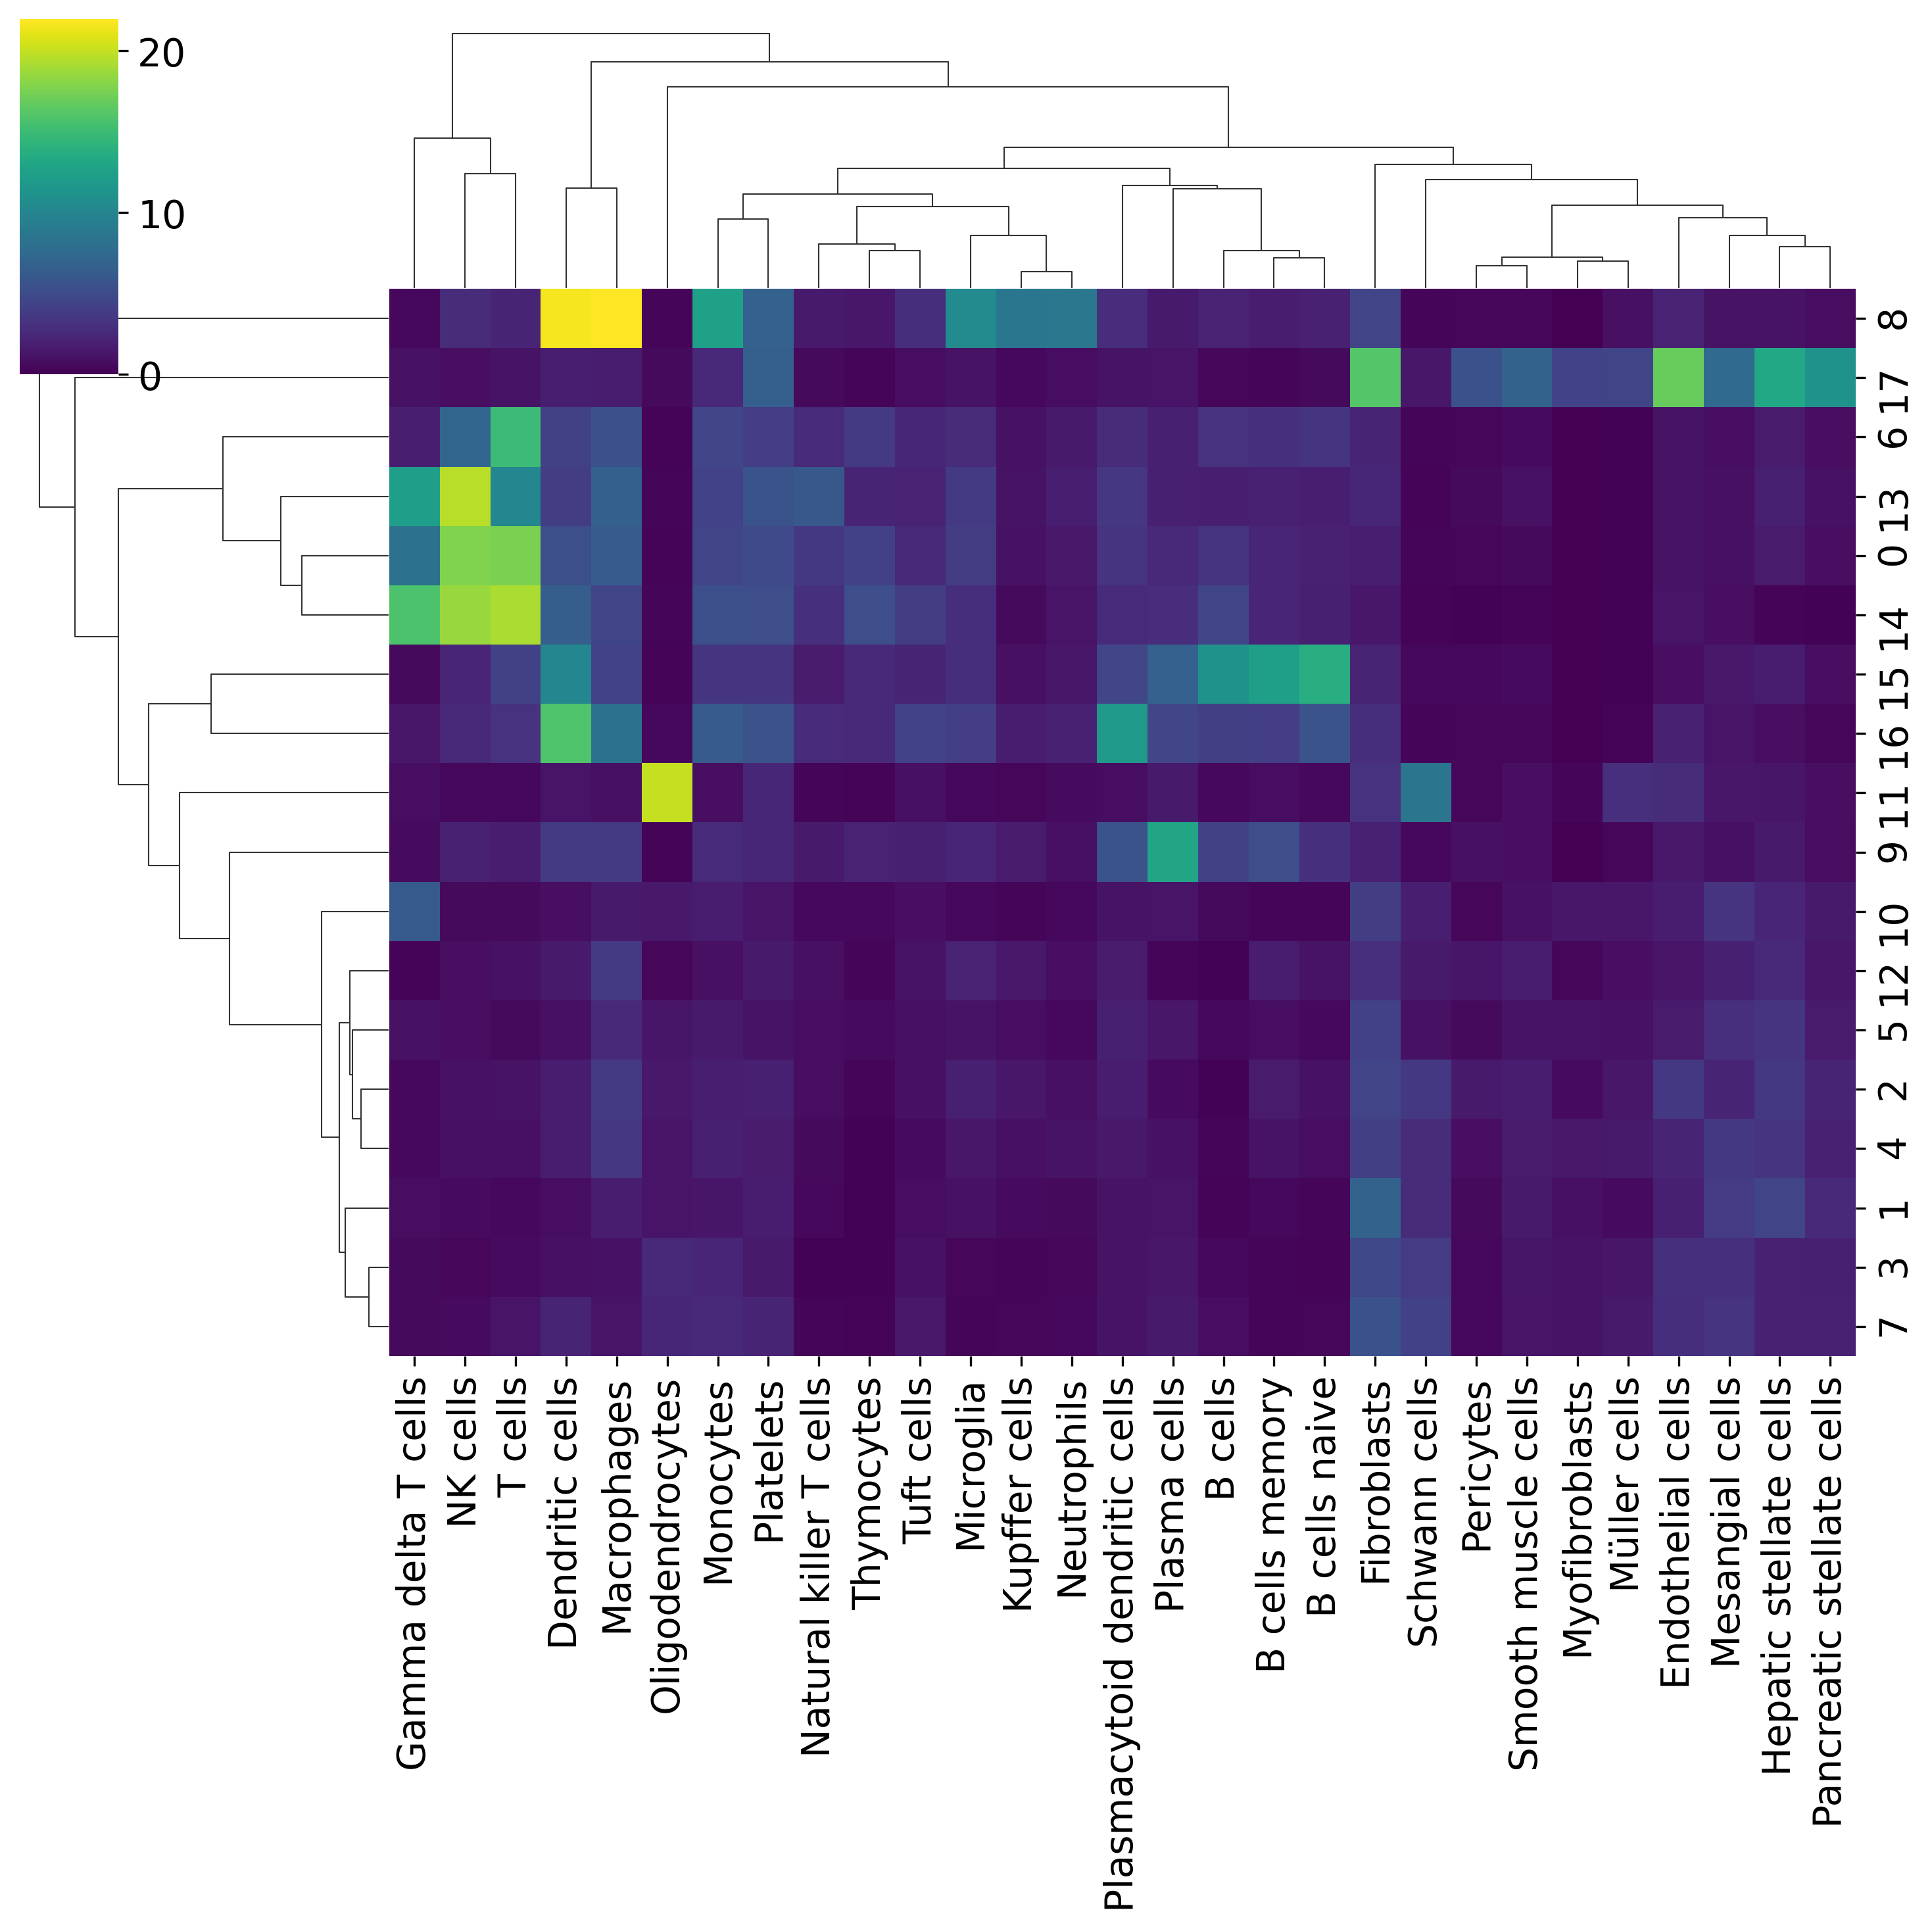

In [69]:
sns.clustermap(mean_enr, xticklabels=mean_enr.columns, cmap='viridis')
plt.show()

In [70]:
annotation_dict = dc.assign_groups(mean_enr)
annotation_dict

{'0': 'NK cells',
 '1': 'Fibroblasts',
 '10': 'Gamma delta T cells',
 '11': 'Oligodendrocytes',
 '12': 'Macrophages',
 '13': 'NK cells',
 '14': 'T cells',
 '15': 'B cells naive',
 '16': 'Dendritic cells',
 '17': 'Endothelial cells',
 '2': 'Fibroblasts',
 '3': 'Fibroblasts',
 '4': 'Fibroblasts',
 '5': 'Fibroblasts',
 '6': 'T cells',
 '7': 'Fibroblasts',
 '8': 'Macrophages',
 '9': 'Plasma cells'}

... storing 'cell_type' as categorical


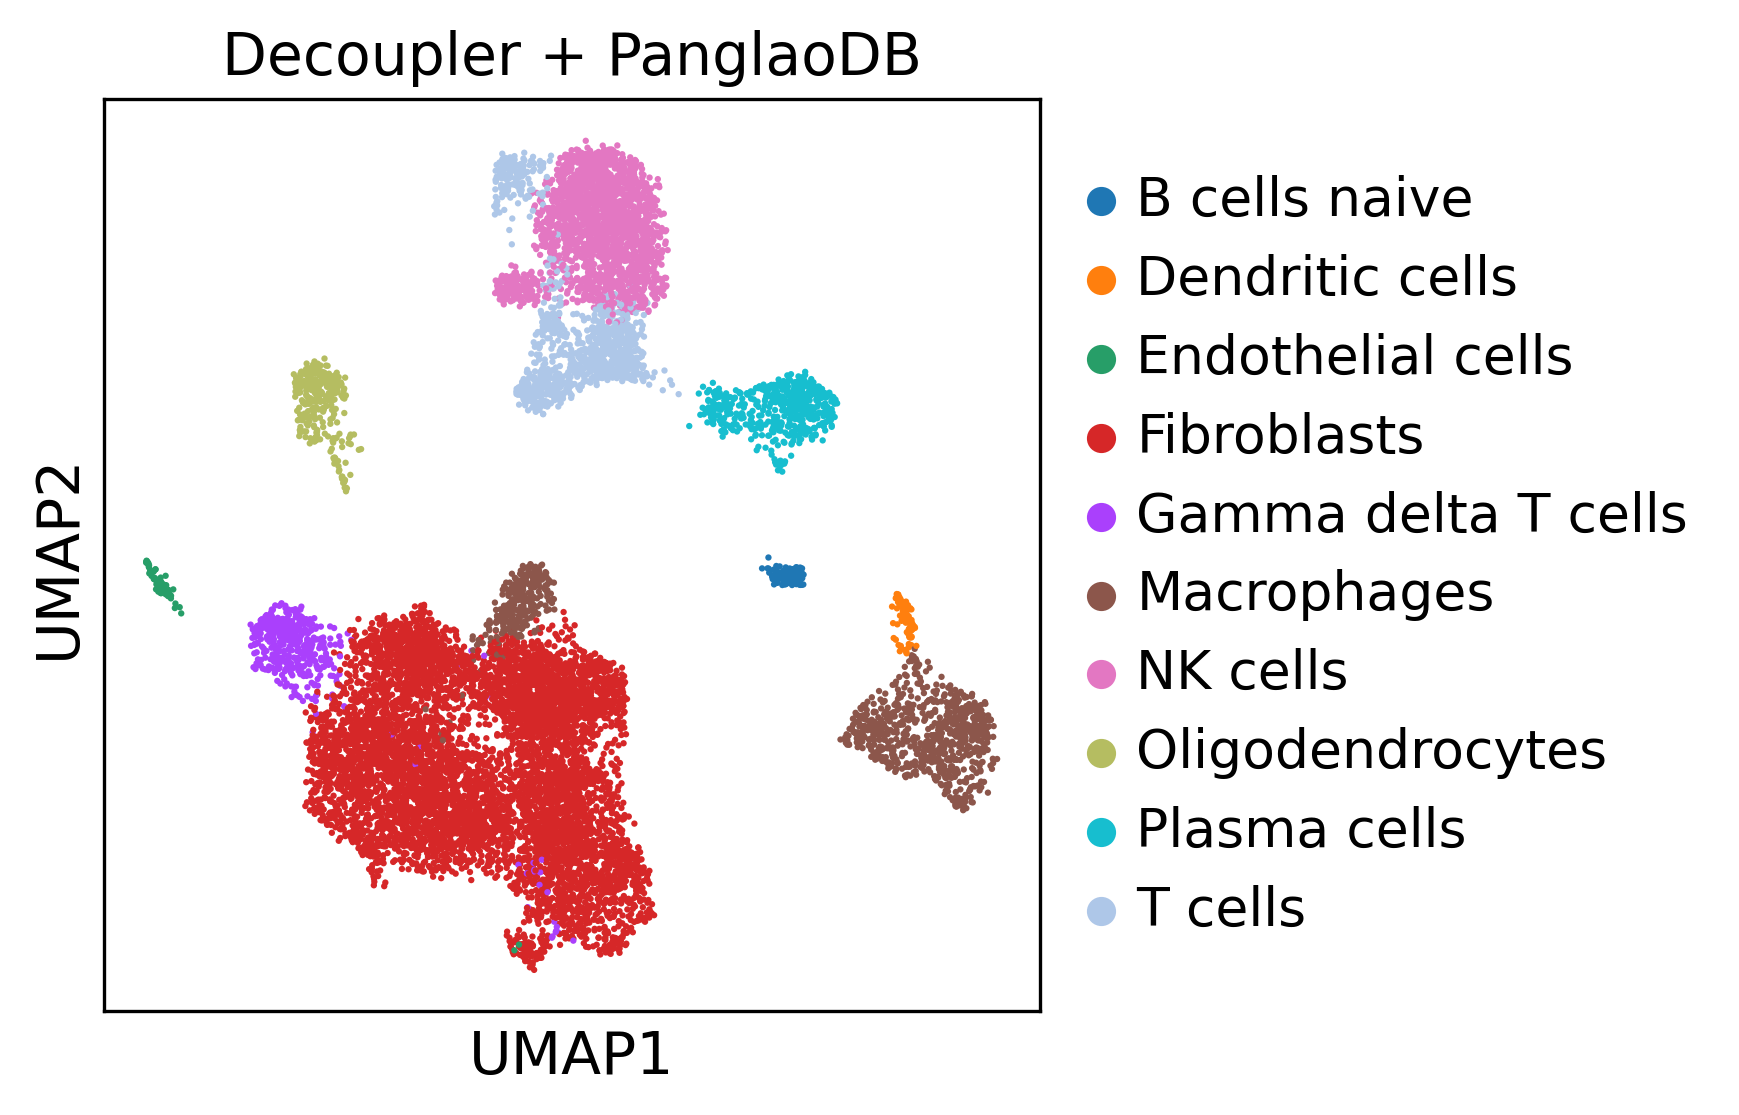

In [71]:
# Add cell type column based on annotation
adata.obs['cell_type'] = [annotation_dict[clust] for clust in adata.obs['leiden']]

# Visualize
sc.pl.umap(adata, color='cell_type',title='Decoupler + PanglaoDB')

In [72]:
adata

AnnData object with n_obs × n_vars = 12942 × 4299
    obs: 'SampleID', 'GEO_RNA', 'Cohort', 'Type', 'Subtype', 'Diagnosis', 'Grade', 'Location', 'IDH1_Status', 'EGFR_Status', 'MGMT', 'CellCount', 'Sample', 'Sex', 'Age', 'Sorted', 'MET', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'leiden', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'SampleID_colors', 'doublet_info_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'majority_voting_colors', 'leiden_colors', 'cell_type_colors'

In [74]:
adata.write("/home/lugli/spuccio/Projects/SP039/FileH5AD_concatenated/Part1_M_GSE174401_PMID34035069.h5ad")